Поскольку нашей целью в этом руководстве является реализация фильтра Калмана в программном коде, мы будем рассматривать это руководство только для дискретного фильтра Калмана.


Приложения фильтра Калмана: 
- оценка параметров динамических систем по зашумленным измеренениям
- сглаживания сигналов
- прогнозирование (в экономике, распознование речи, предсказание погоды)
- задачи слежения (автопилот)



-  1960 год 
- фильтр Калмана - это частный случай фильтра Байеса
- Оценка состояния для линейных моделей и нормальных распределений

Фильтр Калмана предполагает линейные модели системы - система меняется по линейному закону 


# Базовые математические термины

## Случайная величина

Случайная величина — величина принимает случайные значения. Разные значения с разной вероятностью. Может быть:
- дискретной
- непрерывной (температура в комнате в фиксированное время суток, плотность нефтепродукта в фиксированный момент)





Как определить вероятность попадания случайной величины в какой-то интервал? 

probability density function (pdf) — функция плотности вероятности

## Распределение Гаусса (нормальное распределение)

$pdf(x,\mu,\sigma) = \frac{1}{\sqrt{2 \pi \sigma ^2}} e^{-\frac{{(x - \mu)}^{2}}{2\sigma^{2}}}$

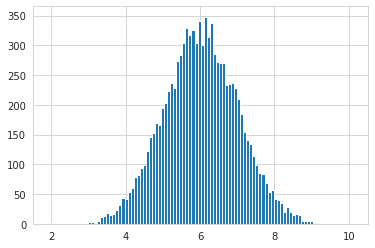

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

tries = 10000
mean = 6
std = 1

simulations = np.random.normal(mean, std, tries)

bins = 100
_, bins, patches = plt.hist(simulations, bins=bins)
plt.show()

Все модели, используемые в фильтрах Калмана имеют Гауссовы распределения

Свойства нормального распределения: 

Если вектор распределен нормально, то и состовляющие нормальные, так же и условные вероятности нормальны

Маргинализация (маргинальное распределение) тоже нормальное

## Среднее значение

Среднее значение случайной величины — это то, что мы получим в пределе, если проведем очень много экспериментов, и посчитаем среднее арифметическое выпавших значений. 

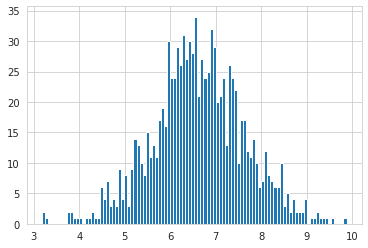

среднее значение: 6.611720225111871


In [33]:
tries = 1000
mean = 6.6
std = 1

simulations = np.random.normal(mean, std, tries)

bins = 100
_, bins, patches = plt.hist(simulations, bins=bins)
plt.show()

print(f'среднее значение: {simulations.mean()}')

## Дисперсия, СКО, Ковариация

Как охарактеризовать изменчивость?

Дисперсия (variance), стандартное отклонение (Standard Deviation)

Дисперсия — среднее квадрата расстояний от каждой точки данных до среднего 

В случае с распределением Гаусса мы совершенно четко видим, что случайная величина предпочитает выпадать в некоторой окрестности своего среднего значения .

Среднеквадратичное отклонение (СКО) — корень из дисперсии, хорошая оценка разброса случайной величины (в единицах измерения случайно величины, в отличии от дисперсии)

Ковариация — оценка разброса 2х переменных

Если ковариация близка к нулю — зависимость не близка к линейной

Коэффициент корреляции — это ковариация, нормированная СКО 
Коэффициент корреляции в статистике более удобен, так как он находится от -1 и 1.


Но что делать, если большое кол-во случайных величин: 
для оценки зависимости исопользуют матрицу ковариации
$Cov(X, Y)$

$Cov(X, X)$ — хотим изучать связи между случайными величинами, которые входят в этот вектор, на диагонале такой матрицы дисперсии

Ковариационная матрица — это тип матрицы, которая используется для представления значений ковариации между парами элементов, заданных в случайном векторе. Ковариационная матрица также может называться дисперсионной ковариационной матрицей. Это связано с тем, что дисперсия каждого элемента представлена вдоль главной диагонали матрицы.

# Алгоритм фильтра Калмана

Для прогнозирования текущего состояния требуется только предполагаемое состояние из предыдущего временного шага и текущее измерение.

Процесс фильтра Калмана состоит из двух этапов: 
- шаг предсказания, на котором предсказывается следующее состояние системы с учетом предыдущих измерений (на основе динамической модели системы)
- шаг обновления, на котором текущее состояние системы оценивается с учетом измерений на текущем временном шаге

$$\begin{equation}
x_t = A x_{t-1} + B u_t + \epsilon_t \\
z_t = H x_t + \delta_t
\end{equation}$$

- $x_t$ — состояние системы
- $u_t$ — управление
- $z_t$ — измерение
- $A$ — матрица системы (nxm), описывающая переход состояния от t-1 до t без управления и шума
- $B$ — матрица (nxl), описывающая как управление действет на изменение состояния от t-1 до t без управления и шума
- $H$ — матрица (kxn), описывающая отображение состояния $x_t$ на измерение $z_t$ 

- $\epsilon_t$, $\delta_t$ — Гауссов шум с нулевой медианой, случайные переменные описывающие шум процесса и измерений. Шумы считаются независимыми и нормально распределенными с ковариацией $Q$ и $R$ соответсвенно

\begin{equation}
p( \epsilon_t) \sim N(0, Q)
\end{equation}

\begin{equation}
p( \delta_t) \sim N(0, R)
\end{equation}

## Шаг прогноза

Этот шаг должен предсказать среднее значение $X$ и ковариацию $P$ состояния системы на временном шаге t. 

C использование модели динамических уравнений состояния:

\begin{equation}
x_t = A x_{t-1} + B u_t
\end{equation}

Затем расчитывается ковариационная матрица ошибок $P_t$:

\begin{equation}
P_t = AP_{t-1}A^T + Q
\end{equation}

$P_{t-1}$ - оценка ковариции матрицы ошибок на шаге $t-1$; 
$Q$ - ковариация шума

## Шаг коррекции

\begin{equation}
K_t = P_t H^T(HP_tH^T + R)^{-1}
\end{equation}

$K$ - усиление Калмана \
$R$ - ковариация шума измерения

- Измерения $z_t$
- Чтобы обновить $x_t$, необходимо измерить невязку. Вычисляется разница между истинным, измеренным значением $z_t$ и предыдущим оценочным измерением $Hx_t$
Тогда остаток равен 
\begin{equation}
z_t - Hx_t
\end{equation}
- Обновление прогнозируемой оценки, суммируется оценка состояния до и смещение
\begin{equation}
x_t = x_t + K_t(z_t - Hx_t)
\end{equation}
- Вычисление обновленной матрица ковариации ошибок:
\begin{equation}
P_t = (I - K_tH)P_t
\end{equation}
где $I$ – единичная матрица

# Пример 1

\begin{cases}
x_t & = x_{t-1} +  v_{t-1}dt\\
v_t&= v_{t-1}
\end{cases}

$$\begin{aligned}
\mathbf z_t & = \begin{pmatrix} x_t \\ v_t \end{pmatrix} + \epsilon
\end{aligned}$$

$$\begin{aligned}
A = \begin{pmatrix} 1 & dt \\ 0 & 1\end{pmatrix} \
R = \begin{pmatrix} 0 & 0 \\ 0 & \sigma \end{pmatrix}
\end{aligned}$$

$$\begin{aligned}
H = \begin{pmatrix} 1 & 0 \\ 0 & 1\end{pmatrix} \
Q = \begin{pmatrix} \sigma_{\epsilon} & 0 \\ 0 & \sigma \end{pmatrix}
\end{aligned}$$

$$\begin{aligned}
B = \begin{pmatrix} 1  \\ 0 \end{pmatrix} \
\end{aligned}$$

# Пример 2

\begin{cases}
x &= \frac{1}{2}at^2 + v_0t + x_0\\
v&=at\\
\end{cases}

$$ \mathbf v = \frac{d \mathbf x}{d t}, 
\quad \mathbf a = \frac{d \mathbf v}{d t} = \frac{d^2 \mathbf x}{d t^2}
$$


$$\begin{aligned}
\mathbf x_k &= \mathbf{Hx}_{k-1}  = \begin{bmatrix} 1 & \Delta t \\ 0 & 1\end{bmatrix}
\begin{bmatrix}x_{k-1} \\ \dot x_{k-1}\end{bmatrix}
\end{aligned}$$

$$\begin{aligned}
\mathbf x_k & = \begin{bmatrix} x_k \\ \dot x_k \end{bmatrix} = \mathbf{Hx}_{k-1}  = \begin{bmatrix} 1 & \Delta t \\ 0 & 1\end{bmatrix}
\begin{bmatrix}x_{k-1} \\ \dot x_{k-1}\end{bmatrix} + \begin{bmatrix} 1/2  (\Delta t) ^{2}\\ (\Delta t)\end{bmatrix} \ddot x_{t-1}
\end{aligned}$$

....


# Пример использования библиотечной функции

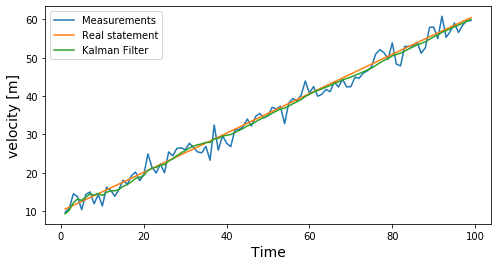

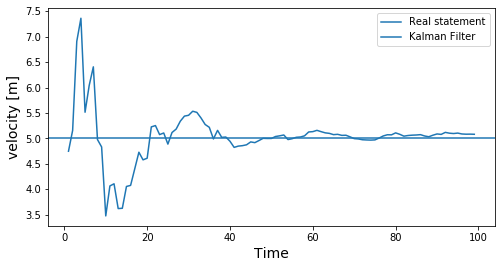

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
np.random.seed(2)

def simulation():
        
    dt = 0.1
    A = np.array([[1, dt], [0, 1]])
    Q = 1e-2*np.array([[1/4*dt**4, 1/2*dt**3], [1/2*dt**3, dt**2]])
    R = 2.
    itr  = 100

    # имитируем работу датчика
    real_state = []
    x = np.array([10, 5]).reshape(2,1)
    
    for i in range(itr):
        real_state.append(x[0, 0])
        x = np.dot(A, x) + np.random.multivariate_normal(mean=(0, 0), cov=Q).reshape(2, 1)
    
    measurements = [x + np.random.normal(0, R) for x in real_state]
    
    # initialization
    P = np.array([[10, 5], [5, 10]])
    x = np.random.multivariate_normal(mean=(10, 5),cov=P).reshape(2, 1)
    
    #filter
    kf = KalmanFilter(dim_x=2, dim_z=1)  #dim_x: размер скрытого состояния, dim_z: размер измерения
    # Определить параметры
    kf.x = x # Начальное состояние [положение, скорость]
    kf.A = A # Матрица перехода состояний
    kf.H = np.array([[1.,0.]])  # Матрица измерений
    kf.P = P # Первоначальная ковариация состояния
    kf.R = R # Измерение шума
    kf.Q = Q_discrete_white_noise(dim=2, dt=dt, var=1e-2) # Процессный (системный) шум

    filter_result = list()
    filter_result.append(x)
    
    for i in range(1, itr):
        z = measurements[i]
        kf.predict()
        kf.update(z)
        filter_result.append(kf.x)
    filter_result=np.squeeze(np.array(filter_result))
    
    return measurements, real_state, filter_result

def plot_result(measurements,real_state,filter_result):
    
    plt.figure(figsize=(8,4))
    plt.plot(range(1,len(measurements)), measurements[1:], label = 'Measurements')
    plt.plot(range(1,len(real_state)), real_state[1:], label = 'Real statement' )
    plt.plot(range(1,len(filter_result)), np.array(filter_result)[1:,0], label = 'Kalman Filter')
    plt.legend()
    plt.xlabel('Time',fontsize=14)
    plt.ylabel('velocity [m]',fontsize=14)
    plt.show()
    
    plt.figure(figsize=(8,4))
    plt.axhline(5, label='Real statement') #, label='$GT_x(real)$'
    plt.plot(range(1,len(filter_result)), np.array(filter_result)[1:,1], label = 'Kalman Filter')
    plt.legend()
    plt.xlabel('Time',fontsize=14)
    plt.ylabel('velocity [m]',fontsize=14)
    plt.show()

if __name__ == '__main__':
    
    measurements, real_state, filter_result = simulation()
    plot_result(measurements, real_state, filter_result)

# Пример 3

https://machinelearningspace.com/object-tracking-python/#id2025936140

Задача слежения за розовым прямоугольником, который перемещается между двумя точками на изображении либо влево, либо вправо. 


Верхняя строка указывает шум. Измерения основаны на фактическом положении цели, но со случайным нормальным распределением между -1 и 1, шум измерения относительно высок - в нашем случае это означает, что измерение в худшем случае составляет до 300 пикселей слева или справа для реального положения

см. файл 1_kalman_example


# Структура алгоритма


Фильтр Калмана использует динамику, чтобы устранить влияние шума и получить точную оценку местоположения в настоящее время (фильтрация), в будущем (прогнозирование), или когда-то в прошлом (интерполяция или сглаживание)

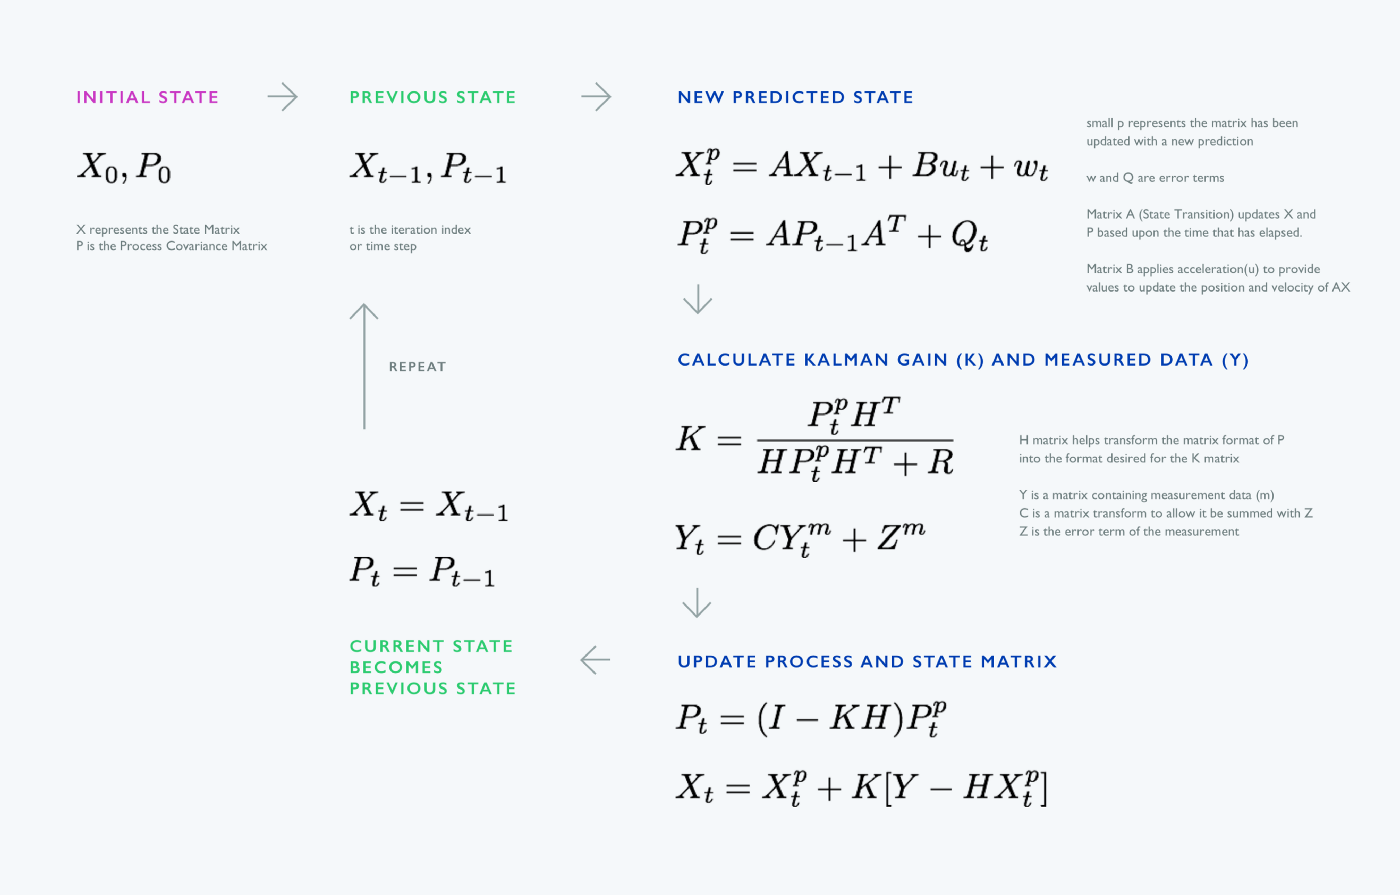

# Допущение фильтра Калмана

- Гауссиановы распределение и шумы
- Линейные модели

нелинейные функции приводят к нелинейным распределением, необходимо линеаризовать нелинейные модели

Для линеаризации. Вспоминаем Матрицу Якоби (ориентация касательной гиперплоскости к функции вектора заданной точки)